<a href="https://www.kaggle.com/code/joshuacurtiswebb/spx-option-backtester?scriptVersionId=131637704" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = False
purchase_time = '15:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0


files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
    #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db


# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

#########
# Abstract Strategy & Abstract Policy
#########

class AbstractStrategy(ABC):
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        self.df_trades = None
       
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c'] + df_trades['lost_p']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n"
            )
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        return risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractPolicy(ABC):
    def getRoundedSlippedPrice(self,bid,ask, trans_type):
        mid = (bid + ask)/0.02
        if mid % 1 != 0.0:
            # We need to slip the bid/ask spread
            if trans_type == 'sell':
                ask -= 0.05
            elif trans_type=='buy':
                bid += 0.05

        mid = round((bid + ask)/0.02,1)
        return mid
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"WARNING : get_contract_strike no records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']
        
        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")
        
        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

In [3]:
#########
# AbstractEntry, AbstractDynamicEntryPolicy, AbstractStaticEntryPolicy
#########

class AbstractEntryPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

class AbstractDynamicEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission):
        super().__init__(commission)
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission, dte, trade_time):
        self.dte = dte
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass

In [4]:
#####
# Dynamic Entry Policies
#####

class AlwaysOpenShortStraddleDynamicEntryPolicy(AbstractDynamicEntryPolicy):
    def __init__(self, commission, dte, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.dte = dte
        self.summary = f"Dynamic Entry Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission)
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        df_trades = None
        if (df_trade_row is None or (df_trade_row['expiration'] == eval_date and eval_time=='16:00:00') or df_trade_row['expiration'] < eval_date or df_trade_row['lost_p']>0 or df_trade_row['lost_c']>0):
            #populate a new trade
            strike_sc, delta_sc, collected_sc, strike_sp, delta_sp, collected_sp, trade_count = 0,0,0,0,0,0,0
            expiration_p, expiration_c = None, None

            # create call/put dataframe slice if needed
            df_purchase_time = df_data[(df_data['dte']==self.dte) & (df_data['quote_time'] == eval_time)]
            df_c = df_purchase_time[(df_purchase_time['type']=="C")]
            df_p = df_purchase_time[(df_purchase_time['type']=="P")]
            
            if df_c.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No calls were found with static rules: {eval_date} | {eval_time}")
            else:
                ##### SHORT CALL #####
                expiration_c = df_c['expiration'].min()
                df_sc = df_c[(df_c['delta']<= self.delta_sc)]
                df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                # print(f"get_contract_strike : {eval_date}, {expiration_c}, {self.delta_sc}, {df_sc.shape[0]}")
                strike_sc, delta_sc, collected_sc = self.get_contract_strike(eval_date, expiration_c,self.delta_sc, df_sc,'sell')

                
            if df_p.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No puts were found with static rules: quote date : {eval_date}")
            else:
                #### SHORT PUT ####
                expiration_p = df_p['expiration'].min()
                df_sp = df_p[(df_p['delta']<= self.delta_sp)]
                df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                strike_sp, delta_sp, collected_sp = self.get_contract_strike(eval_date, expiration_p,self.delta_sp, df_sp,'sell')


            if strike_sc > 0.0:
                trade_count += 1
            if strike_sp > 0.0:
                trade_count += 1
                
            if trade_count == 0:
                return None

            if expiration_p is not None and expiration_c is not None and expiration_p != expiration_c:
                print("ERROR : put and call expirations are different within single straddle transaction. Trade nullified")
                return None
            else:
                expiration = expiration_p or expiration_c
            
            df_trades = pd.DataFrame([{'trade_date':eval_date, 'expiration':expiration, 'trade_count':trade_count, 
                               'delta_sc_target' : self.delta_sc,'delta_sp_target': self.delta_sp, 'strike_sc': strike_sc, 
                               'delta_sc':delta_sc, 'collected_sc': collected_sc, 'strike_sp': strike_sp,'delta_sp': delta_sp, 
                               'collected_sp': collected_sp, 'collected': collected_sc + collected_sp, 'lost_c': 0, 'lost_p' : 0}])
        
        return df_trades
    
    def __str__(self):
        self.summary

    def __repr__(self):
        self.summary

In [5]:
#### Basic Strategy Types

class StaticEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, timestep, debug = False):
            entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
            exit_policy = AbstractDynamicExitPolicy(commission, timestep)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        
        
        self.df_trades['lost_c'] = 0.0
        self.df_trades['lost_p'] = 0.0
        
        df_times = pd.DataFrame(df['quote_time'].unique())
        df_times[0] = pd.to_datetime(df_times[0], format='%H:%M:%S').dt.time
        df_times.rename(columns={0: "quote_time"},inplace=True)
        df_times = df_times.sort_values(by='quote_time')
        
        start_time_timer = perf_counter()
        for index, trow in df_times.iterrows():           
            min_i = int(trow[0].strftime("%M"))
            curr_time = trow[0]
            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            if (end_time < curr_time or curr_time <= start_time):
                continue
            str_quote_time = trow[0].strftime("%H:%M:%S")
            df_qt = df[(df['quote_time']==str_quote_time)]

            # print(f"Num rows at {str_quote_time} : {df_qt.shape[0]}")

            self.df_trades['trade_count'],self.df_trades['lost_c'], self.df_trades['lost_p'] = self.df_trades.apply(
                lambda row : self.exit_policy.evaluateTradingCondition(None, str_quote_time, row, df_qt), axis=1).T.values
            stop_time_timer = perf_counter()
            # print(df_trades.head())

            if min_i % 30 == 0:
                print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticEntryHoldToExpStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv):
        entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
        exit_policy = AbstractStaticExitPolicy(commission, trade_time)
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission)
        
    def evaluate(df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class DynamicEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, debug = False):
            entry_policy = AbstractDynamicEntryPolicy(commission)
            exit_policy = AbstractDynamicExitPolicy(commission, None)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        df.loc[:,'quote_datetime'] = pd.to_datetime(df['quote_date'].astype(str)+' '+df['quote_time'].astype(str))
        df_datetimes = pd.DataFrame(df['quote_datetime'].unique())
        df_datetimes.rename(columns={0: "quote_datetime"},inplace=True)
        df_datetimes = df_datetimes.sort_values(by='quote_datetime')

        start_time_timer = perf_counter()
        df_dt = None
        for index, trow in df_datetimes.iterrows():
            day_i = int(trow[0].strftime("%d"))
            hour_i = int(trow[0].strftime("%H"))

            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            curr_time = trow[0].time()
            str_quote_time = curr_time.strftime("%H:%M:%S")
            curr_date = pd.to_datetime(trow[0]).floor('D')

            if (end_time < curr_time or curr_time < start_time):
                continue

            # To save computation, pre-filter each time the date changes
            if df_dt is None or df_dt['quote_date'].iloc[0] != curr_date:
                df_dt = df[df['quote_date']==curr_date]
                #print(f"Iteration date : {curr_date} and time {str_quote_time}. DF rows {df.shape[0]}. df_dt rows : {df_dt.shape[0]}")

            # Design decision : we'll just try to enter and exit once each minute. This means that if we exit a position,
            # about 1 minute will pass before we decide to re-enter
            # 
            # To keep evalute trading decision method signature the same, we'll pass in a row: the last row of df_trades.
            # This leaves the possibility of having no rows.
            # Thus, every dynamic policy must account for getting no row.
            last_trade = None
            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            new_trade = self.entry_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
            if new_trade is not None:
                self.df_trades = pd.concat([self.df_trades, new_trade], ignore_index=True)

            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            if last_trade is not None:
                if last_trade['expiration'] >= curr_date:
                    #print(f"call : evaluateTradingCondition {curr_date}, {str_quote_time}, {last_trade['expiration']}, {df_dt.shape[0]}")
                    trade_count, lost_c, lost_p = self.exit_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
#                     if lost_c > 0 or lost_p > 0:
#                         print("Trying to propagate a loss into the future.")
                    self.df_trades.loc[self.df_trades.index[-1],'trade_count'] = trade_count
                    self.df_trades.loc[self.df_trades.index[-1],'lost_c'] = lost_c
                    self.df_trades.loc[self.df_trades.index[-1],'lost_p'] = lost_p

            
            
            stop_time_timer = perf_counter()

            if day_i == 28 and hour_i == 16:
                print(f"Processed {trow.iloc[0]} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    


In [6]:
class AlwaysOpenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(DynamicEntryDynamicExitStrategy):
    def __init__(self, commission, dte, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
            self.entry_policy = AlwaysOpenShortStraddleDynamicEntryPolicy(commission, dte, delta_sp, delta_sc)
            self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
            self.df_ty = df_ty
            self.initial_portfolio_value = ipv
            self.commission = commission
            self.debug = debug
            self.summary = f"Always open short straddle after max loss {max_loss}. SP : {delta_sp} SC : {delta_sc}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])

    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [7]:
    
    
class AbstractExitPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractDynamicExitPolicy(AbstractExitPolicy):
    def __init__(self, commission, timestep):
        self.timestep = timestep
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
    
class ShortStraddleStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.summary = f"Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No puts were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc,'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp,'sell'), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] 
        
        return df_trades
    
class ShortIronCondorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.delta_lp = delta_lp
        self.delta_lc = delta_lc
        self.summary = f"Short Iron Condor. SP Delta : {round(delta_sp,3)} SC Delta : {round(delta_sc,3)} LP Delta : {round(delta_lp,3)} LC Delta : {round(delta_lc,3)}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        df_trades['delta_lc_target'] = self.delta_lc
        df_trades['delta_lp_target'] = self.delta_lp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        df['delta_lc_target'] = self.delta_lc
        df['delta_lp_target'] = self.delta_lp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc, 'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp, 'sell'), axis = 1).T.values
        
        ###### LONG CALL #####
        df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
        df_lc = df_lc.loc[df_lc.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_lc, 'buy'), axis = 1).T.values
        df_trades['collected_lc'] = df_trades['collected_lc']*-1
            
        ###### LONG PUT #####
        df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]
        df_lp = df_lp.loc[df_lp.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp, 'buy'), axis = 1).T.values
        df_trades['collected_lp']=df_trades['collected_lp']*-1
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] + df_trades['collected_lc'] + df_trades['collected_lp']
        
        return df_trades

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    

    
class StaticShortIronCondorDynamicMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)        
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class MaxLossDynamicExitPolicy(AbstractDynamicExitPolicy):
    def __init__(self, commission, timestep, max_loss):
        self.max_loss = max_loss
        super().__init__(commission, timestep)
    
    def populateTrades(self, df):
        pass
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        row = df_trade_row
        expiration, collected, lost_c, lost_p, trade_count  = row['expiration'], row['collected'], row['lost_c'], row['lost_p'], row['trade_count']
        if lost_c > 0.0 or lost_p > 0.0:
            return pd.Series([trade_count, lost_c, lost_p])
        
        if (eval_time == '16:00:00' and eval_date == row['expiration']):
            #print(f"evaluating end of day")
            lost_c, lost_p = self.get_amount_lost(df_data,row)
#             if lost_c>0 or lost_p>0:
#                 print(f"We have a loss! eval_date {eval_date}, {df_trade_row}")
            return pd.Series([trade_count,lost_c, lost_p])

        eval_date = eval_date or expiration
        
        df1 = df_data[(df_data['quote_date'] == eval_date) & (df_data['expiration'] == expiration) & (df_data['quote_time']==eval_time)]
#         print(f"Num rows at {expiration} : {df1.shape[0]}")
        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
        
        potential_loss = collected + mark_to_market_c + mark_to_market_p
        
        #print(f"Potential Loss : {potential_loss} | collected : {collected}")
        
        if (potential_loss < 0) and (abs(potential_loss/collected) >= self.max_loss):
#             print(f"Exp: {expiration}. Eval time : {eval_time}. Collected : {collected}, MTMC : {mark_to_market_c}, MTMP : {mark_to_market_p}. Projected loss : {abs(potential_loss/collected)}")
#             print(df_sp.head(5))
            trade_count += potential_trade_count
            lost_c += -1*mark_to_market_c
            lost_p += -1*mark_to_market_p
#             print(f"early exit loss! : {row}, eval_date : {eval_date}. eval_time : {eval_time}")
                
        return pd.Series([trade_count,lost_c,lost_p])
    
    
    def len_check(self,df, opt_type, strike, contract_date, quote_time):
        if len(df)==0:
            raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def __str__(self):
        return f"Max Loss: {self.max_loss}"

    def __repr__(self):
        return f"Max Loss: {self.max_loss}"
    


Processed 2022-01-28 16:00:00 | Elapsed : 50.86040058599974
Processed 2022-02-28 16:00:00 | Elapsed : 55.974116372000026
Processed 2022-03-28 16:00:00 | Elapsed : 55.201519668999936
Processed 2022-04-28 16:00:00 | Elapsed : 58.000736748000236
Processed 2022-06-28 16:00:00 | Elapsed : 118.68518298699973
*****  BACKTEST RESULTS  ****

Cumulative return:                      6.045 % 
Max Drawdown:                          -1.083 % 
Trading Days:                             116 
Wins:                                      96 
Losses:                                    20 
Breakeven:                                  0 
Win/Loss Ratio:                        82.759 % 
Mean Win:                             170.359 $ 
Mean Win Trans Return:                  0.173 % 
Mean Loss:                            -528.45 $ 
Mean Loss Trans Return:                -0.534 % 
Mean Net Trans:                        49.875 $ 
Mean Trans Return:                      0.051 % 
Std Dev of Net Trans:               

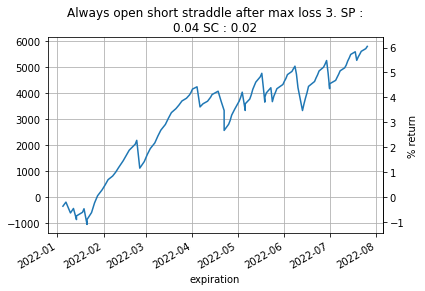

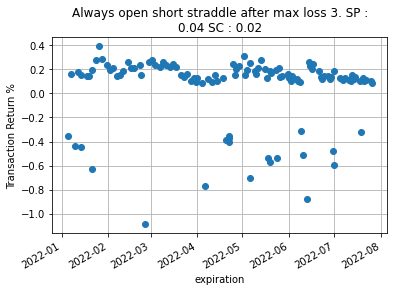

In [8]:
strat2 = AlwaysOpenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(commission,1,0.04, 0.02, df_ty, initial_portfolio_value, 3, debug = True)
sharp = strat2.evaluate(df)

# strat1 = StaticShortStraddleMaxLossExitStrategy(commission,1,purchase_time,0.08, 0.08, df_ty, initial_portfolio_value, 2, debug = True)
# sharp = strat1.evaluate(df)
# strat = StaticShortIronCondorHoldToExpStrategy(commission,1,purchase_time,0.09,0.09, 0.01, 0.01, df_ty, initial_portfolio_value, debug = True)
# strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.08,0.08, df_ty, initial_portfolio_value, debug = True)
# sharp = strat.evaluate(df)


# entry_policy = ShortStraddleStaticEntryPolicy(commission, 1, purchase_time, 0.04,0.02)
# df_trades = entry_policy.populateTrades(df)
# df_trades


In [9]:
strat2.df_trades.iloc[8:]

,trade_date,expiration,trade_count,delta_sc_target,delta_sp_target,strike_sc,delta_sc,collected_sc,strike_sp,delta_sp,collected_sp,collected,lost_c,lost_p,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return
8,2022-01-20,2022-01-21,4.0,0.02,0.04,4695.0,0.0173,40.0,4405.0,0.0398,140.0,180.0,10.0,765.0,6.0,775.0,-601.0,94671.5,-1036.5,-0.006308,-0.01083,0.000007
9,2022-01-20,2022-01-21,2,0.02,0.04,4620.0,0.0164,35.0,4315.0,0.0394,155.0,190.0,0,0,3.0,0,187.0,94858.5,-849.5,0.001975,-0.008876,0.000007
10,2022-01-21,2022-01-24,2.0,0.02,0.04,4570.0,0.0186,55.0,4170.0,0.0396,215.0,270.0,0.0,0.0,3.0,0.0,267.0,95125.5,-582.5,0.002815,-0.006086,0.000006
11,2022-01-25,2022-01-26,2.0,0.02,0.04,4600.0,0.0200,85.0,4025.0,0.0380,290.0,375.0,0.0,0.0,3.0,0.0,372.0,95497.5,-210.5,0.003911,-0.002199,0.000007
12,2022-01-27,2022-01-28,2,0.02,0.04,4595.0,0.0199,65.0,4165.0,0.0383,210.0,275.0,0,0,3.0,0,272.0,95769.5,61.5,0.002848,0.000643,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2022-07-19,2022-07-20,2,0.02,0.04,4020.0,0.0192,30.0,3800.0,0.0380,105.0,135.0,0,0,3.0,0,132.0,101090.5,5382.5,0.001307,0.056239,0.000097
112,2022-07-20,2022-07-21,2,0.02,0.04,4070.0,0.0143,25.0,3860.0,0.0356,80.0,105.0,0,0,3.0,0,102.0,101192.5,5484.5,0.001009,0.057305,0.000094
113,2022-07-21,2022-07-22,2,0.02,0.04,4095.0,0.0160,25.0,3890.0,0.0369,90.0,115.0,0,0,3.0,0,112.0,101304.5,5596.5,0.001107,0.058475,0.000094
114,2022-07-22,2022-07-25,2,0.02,0.04,4055.0,0.0190,30.0,3870.0,0.0365,75.0,105.0,0,0,3.0,0,102.0,101406.5,5698.5,0.001007,0.05954,0.000093


Processed 10:00:00 | Elapsed : 16.236120952999954
Processed 10:30:00 | Elapsed : 15.543368057999942
Processed 11:00:00 | Elapsed : 15.441646075000335
Processed 11:30:00 | Elapsed : 15.383576277999964
Processed 12:00:00 | Elapsed : 15.284863409999616
Processed 12:30:00 | Elapsed : 15.098033283000404
Processed 13:00:00 | Elapsed : 15.197091390999958
Processed 13:30:00 | Elapsed : 14.933753840999998
Processed 14:00:00 | Elapsed : 15.207161370999984
Processed 14:30:00 | Elapsed : 14.841283350999674
Processed 15:00:00 | Elapsed : 14.919440130000112
Processed 15:30:00 | Elapsed : 14.8575043740002
Processed 16:00:00 | Elapsed : 14.669262665999668
*****  BACKTEST RESULTS  ****

Cumulative return:                      11.42 % 
Max Drawdown:                          -0.353 % 
Trading Days:                             108 
Wins:                                      95 
Losses:                                    13 
Breakeven:                                  0 
Win/Loss Ratio:                    

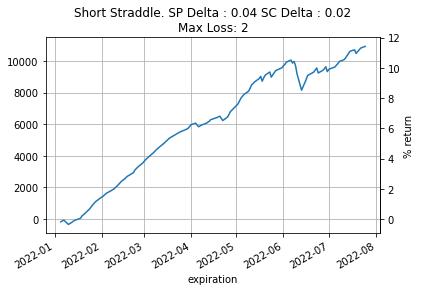

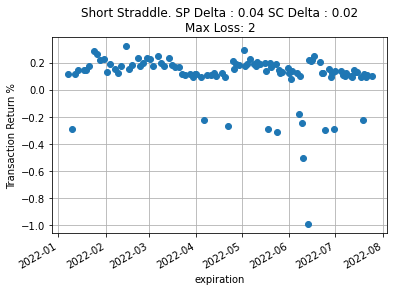

In [10]:
strat1 = StaticShortStraddleMaxLossExitStrategy(commission,1,purchase_time,0.04, 0.02, df_ty, initial_portfolio_value, 2, debug = True)
sharp = strat1.evaluate(df)

In [11]:
strat2.df_trades.iloc[46:53]

,trade_date,expiration,trade_count,delta_sc_target,delta_sp_target,strike_sc,delta_sc,collected_sc,strike_sp,delta_sp,collected_sp,collected,lost_c,lost_p,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return
46,2022-04-13,2022-04-14,2,0.02,0.04,4530.0,0.0179,25.0,4350.0,0.0379,82.5,107.5,0,0,3.0,0,104.5,99649.0,3941.0,0.00105,0.041177,0.000029
47,2022-04-14,2022-04-18,2.0,0.02,0.04,4495.0,0.0174,30.0,4275.0,0.0372,100.0,130.0,0.0,0.0,3.0,0.0,127.0,99776.0,4068.0,0.001274,0.042504,0.000030
48,2022-04-19,2022-04-20,4.0,0.02,0.04,4510.0,0.0161,30.0,4275.0,0.0351,95.0,125.0,500.0,5.0,6.0,505.0,-386.0,99390.0,3682.0,-0.003869,0.038471,0.000033
49,2022-04-21,2022-04-22,2.0,0.02,0.04,0.0,0.0000,0.0,4380.0,0.0365,100.0,100.0,0.0,450.0,3.0,450.0,-353.0,99037.0,3329.0,-0.003552,0.034783,0.000032
50,2022-04-21,2022-04-22,2.0,0.02,0.04,0.0,0.0000,0.0,4325.0,0.0398,110.0,110.0,0.0,472.5,3.0,472.5,-365.5,98671.5,2963.5,-0.003691,0.030964,0.000032
51,2022-04-21,2022-04-22,4.0,0.02,0.04,4510.0,0.0171,30.0,4280.0,0.0369,95.0,125.0,5.0,512.5,6.0,517.5,-398.5,98273.0,2565.0,-0.004039,0.0268,0.000032
52,2022-04-22,2022-04-25,2,0.02,0.04,4450.0,0.0177,45.0,4090.0,0.0392,195.0,240.0,0,0,3.0,0,237.0,98510.0,2802.0,0.002412,0.029277,0.000031


In [12]:
strat1.df_trades.iloc[46:49]

,trade_date,expiration,trade_count,delta_sc_target,delta_sp_target,strike_sc,delta_sc,collected_sc,strike_sp,delta_sp,collected_sp,collected,lost_c,lost_p,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return
46,2022-04-19,2022-04-20,2.0,0.02,0.04,4550.0,0.0158,20.0,4375.0,0.0384,75.0,95.0,0.0,0.0,3.0,0.0,92.0,102220.5,6512.5,0.000901,0.068046,0.000033
47,2022-04-21,2022-04-22,4.0,0.02,0.04,4510.0,0.0184,35.0,4285.0,0.0375,95.0,130.0,5.0,395.0,6.0,400.0,-276.0,101944.5,6236.5,-0.002700,0.065162,0.000032
48,2022-04-22,2022-04-25,2.0,0.02,0.04,4445.0,0.0169,40.0,4110.0,0.0390,175.0,215.0,0.0,0.0,3.0,0.0,212.0,102156.5,6448.5,0.002080,0.067377,0.000031


*****  BACKTEST RESULTS  ****

Cumulative return:                      8.893 % 
Max Drawdown:                          -2.491 % 
Trading Days:                             108 
Wins:                                     101 
Losses:                                     7 
Breakeven:                                  0 
Win/Loss Ratio:                        93.519 % 
Mean Win:                             159.822 $ 
Mean Win Trans Return:                  0.161 % 
Mean Loss:                          -1090.073 $ 
Mean Loss Trans Return:                -0.858 % 
Mean Net Trans:                         78.81 $ 
Mean Trans Return:                      0.104 % 
Std Dev of Net Trans:                 382.217 
Std Dev of Trans Return:                0.003 
Max Loss:                             -2384.0 $ 
Max Win:                                312.0 $ 
Sharpe Ratio static STD:                5.383 
Sharpe Ratio with RF STD:               5.377 
Risk Adj Cumulative Return:          3016.904 



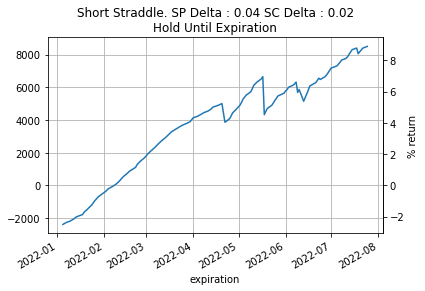

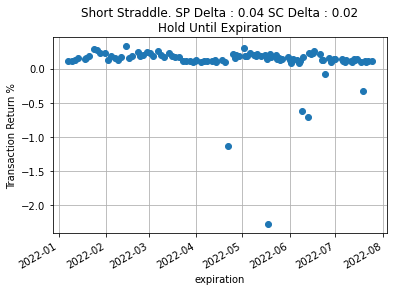

In [13]:
strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.04,0.02, df_ty, initial_portfolio_value, debug = True)
sharp = strat.evaluate(df)

In [14]:
strat2.df_trades.to_csv("ml200_re-entry_2020_sp8_sc_8_2.csv")

In [15]:
strat1.df_trades.to_csv("ml200_no_re-entry_2020_sp8_sc_8.csv")

In [16]:
df[(df['expiration']=='2019-01-04')&(df['type']=='C')&(df['strike']==2555.0)&(df['quote_date']=='2019-01-04')]

,expiration,strike,type,bid,ask,price,implied_volatility,delta,gamma,quote_date,quote_time,dte,quote_datetime,delta_sc_target,delta_sp_target


In [17]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [18]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.55)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.55)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    
    strategy = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,delta_sp_trial,delta_sc_trial, df_ty, initial_portfolio_value)
    score = run_backtest(strategy, df)
    return score

In [19]:
study_name = "optimal-short-straddle-study_2021-2022_1DTE_1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 200)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-05-30 21:59:18,229] Using an existing study with name 'optimal-short-straddle-study_2021-2022_1DTE_1' instead of creating a new one.
[I 2023-05-30 21:59:20,801] Trial 202 finished with value: 31477.178 and parameters: {'delta_sp': 0.011602678851514486, 'delta_sc': 0.014160053215946595}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:23,082] Trial 203 finished with value: 29608.315 and parameters: {'delta_sp': 0.011445288691216061, 'delta_sc': 0.010501224993346828}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:25,359] Trial 204 finished with value: 4744.321 and parameters: {'delta_sp': 0.010754120597675845, 'delta_sc': 0.02709097106379212}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:27,641] Trial 205 finished with value: 31327.297 and parameters: {'delta_sp': 0.0020916495924867356, 'delta_sc': 0.012142864328810336}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:29,931] Trial 206 finished with value: 3870.385 and parameters: {'delta_sp': 0.030381042086708096, 'delta_sc': 0.035038488512455876}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:32,197] Trial 207 finished with value: 26916.457 and parameters: {'delta_sp': 0.012694768306129355, 'delta_sc': 0.0025013421440561266}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:34,605] Trial 208 finished with value: 3999.613 and parameters: {'delta_sp': 0.0020294493023643896, 'delta_sc': 0.021911458235716844}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:36,852] Trial 209 finished with value: 11731.529 and parameters: {'delta_sp': 0.023015215556444087, 'delta_sc': 0.002159120274374267}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:39,101] Trial 210 finished with value: 2729.785 and parameters: {'delta_sp': 0.038685661953525484, 'delta_sc': 0.021473887886337036}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:41,367] Trial 211 finished with value: 32538.15 and parameters: {'delta_sp': 0.0021548784579423635, 'delta_sc': 0.012868357081277511}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:43,554] Trial 212 finished with value: 31899.596 and parameters: {'delta_sp': 0.01349522336089463, 'delta_sc': 0.01338378785756769}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:45,719] Trial 213 finished with value: 32288.236 and parameters: {'delta_sp': 0.011859008822724325, 'delta_sc': 0.015654805884382905}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:47,898] Trial 214 finished with value: 5983.823 and parameters: {'delta_sp': 0.021992012130819062, 'delta_sc': 0.03172661215187712}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 21:59:50,162] Trial 215 finished with value: 4141.595 and parameters: {'delta_sp': 0.0025039926902540154, 'delta_sc': 0.021320919692444148}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:52,474] Trial 216 finished with value: 31540.297 and parameters: {'delta_sp': 0.012219733793973994, 'delta_sc': 0.01385852474170095}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:54,965] Trial 217 finished with value: 3747.194 and parameters: {'delta_sp': 0.012594726239846565, 'delta_sc': 0.03860244992300663}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:57,263] Trial 218 finished with value: 5639.903 and parameters: {'delta_sp': 0.030733761617587813, 'delta_sc': 0.01228129602832407}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 21:59:59,546] Trial 219 finished with value: 4763.573 and parameters: {'delta_sp': 0.01202672136293813, 'delta_sc': 0.025721138791465377}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:01,849] Trial 220 finished with value: 375.174 and parameters: {'delta_sp': 0.002590528175971109, 'delta_sc': 0.33961161798161194}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:04,141] Trial 221 finished with value: 30539.949 and parameters: {'delta_sp': 0.021062094528950505, 'delta_sc': 0.01283282224016744}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:06,416] Trial 222 finished with value: 9132.042 and parameters: {'delta_sp': 0.01769455673715917, 'delta_sc': 0.020210770737849187}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:08,707] Trial 223 finished with value: 30167.361 and parameters: {'delta_sp': 0.011097645300222427, 'delta_sc': 0.010965690845189363}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:10,987] Trial 224 finished with value: 5222.384 and parameters: {'delta_sp': 0.025833457565451967, 'delta_sc': 0.02956481775933923}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:13,233] Trial 225 finished with value: 26880.515 and parameters: {'delta_sp': 0.012916635378028757, 'delta_sc': 0.002519596982214836}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:15,513] Trial 226 finished with value: 4767.753 and parameters: {'delta_sp': 0.034481375788916545, 'delta_sc': 0.020019466789399056}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:17,769] Trial 227 finished with value: 32061.64 and parameters: {'delta_sp': 0.0021265380534235337, 'delta_sc': 0.013548301392048791}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:20,045] Trial 228 finished with value: -398.223 and parameters: {'delta_sp': 0.32098850757352565, 'delta_sc': 0.03318177780793711}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:22,588] Trial 229 finished with value: 14995.634 and parameters: {'delta_sp': 0.0023589311037058676, 'delta_sc': 0.0020142044702186872}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:24,886] Trial 230 finished with value: -444.475 and parameters: {'delta_sp': 0.16727553795752753, 'delta_sc': 0.01221649773214441}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:27,136] Trial 231 finished with value: 3589.76 and parameters: {'delta_sp': 0.002187145385823687, 'delta_sc': 0.02017312579966795}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:29,405] Trial 232 finished with value: 27774.516 and parameters: {'delta_sp': 0.019720130807200153, 'delta_sc': 0.011419156348062131}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:31,659] Trial 233 finished with value: 7144.801 and parameters: {'delta_sp': 0.014293875263977221, 'delta_sc': 0.02450122727908398}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:33,920] Trial 234 finished with value: 14995.634 and parameters: {'delta_sp': 0.0023683579084218948, 'delta_sc': 0.002084397905503089}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:36,186] Trial 235 finished with value: 28490.378 and parameters: {'delta_sp': 0.02202238178099243, 'delta_sc': 0.013332553112910739}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:38,504] Trial 236 finished with value: 3393.171 and parameters: {'delta_sp': 0.01269262501773747, 'delta_sc': 0.034035718586788694}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:40,773] Trial 237 finished with value: -386.549 and parameters: {'delta_sp': 0.4433486049269135, 'delta_sc': 0.02282987054649018}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:43,043] Trial 238 finished with value: 8422.56 and parameters: {'delta_sp': 0.027696327114406255, 'delta_sc': 0.01292382269206587}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:45,293] T

[I 2023-05-30 22:00:49,885] Trial 241 finished with value: 32376.644 and parameters: {'delta_sp': 0.0022996761779251265, 'delta_sc': 0.015764035324203014}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:52,502] Trial 242 finished with value: 30801.696 and parameters: {'delta_sp': 0.011962772159764767, 'delta_sc': 0.012097318232529027}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:54,785] Trial 243 finished with value: 4242.295 and parameters: {'delta_sp': 0.0027615714887576936, 'delta_sc': 0.02141757731708825}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:00:57,050] Trial 244 finished with value: 28925.472 and parameters: {'delta_sp': 0.011319484305362898, 'delta_sc': 0.009974462651000323}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:00:59,338] Trial 245 finished with value: 23277.187 and parameters: {'delta_sp': 0.019545979347126652, 'delta_sc': 0.0024213453746268956}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:01,615] Trial 246 finished with value: 3800.037 and parameters: {'delta_sp': 0.0024524559053681052, 'delta_sc': 0.02043956666051928}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:03,897] Trial 247 finished with value: 3665.958 and parameters: {'delta_sp': 0.030008231272406725, 'delta_sc': 0.03280155565010701}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:06,160] Trial 248 finished with value: 31608.697 and parameters: {'delta_sp': 0.012453404107998079, 'delta_sc': 0.012485942558694509}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:08,461] Trial 249 finished with value: -491.11 and parameters: {'delta_sp': 0.5239116947909419, 'delta_sc': 0.00252735661862878}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:10,768] Trial 250 finished with value: 31957.567 and parameters: {'delta_sp': 0.012085604031338841, 'delta_sc': 0.014381726724906792}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:12,972] Trial 251 finished with value: 5204.935 and parameters: {'delta_sp': 0.013056460706843485, 'delta_sc': 0.02682967150048279}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:15,132] Trial 252 finished with value: 3982.962 and parameters: {'delta_sp': 0.02207040196477677, 'delta_sc': 0.03912075561310277}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:17,276] Trial 253 finished with value: 4461.966 and parameters: {'delta_sp': 0.03390178121916905, 'delta_sc': 0.01395944092992311}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:19,405] Trial 254 finished with value: 4355.911 and parameters: {'delta_sp': 0.002243419279579754, 'delta_sc': 0.02269171704678843}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:21,712] Trial 255 finished with value: 31145.164 and parameters: {'delta_sp': 0.012950311175061041, 'delta_sc': 0.011614375981619445}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:23,835] Trial 256 finished with value: 26856.228 and parameters: {'delta_sp': 0.012679378313744188, 'delta_sc': 0.002110689787344539}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:25,983] Trial 257 finished with value: 5269.977 and parameters: {'delta_sp': 0.025749455693765553, 'delta_sc': 0.030596241230348722}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:28,120] Trial 258 finished with value: 8065.496 and parameters: {'delta_sp': 0.014462092902339527, 'delta_sc': 0.02023123453615584}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:30,698] Trial 259 finished with value: 1998.271 and parameters: {'delta_sp': 0.041778139075504116, 'delta_sc': 0.0438550722481173}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:32,840] Trial 260 finished with value: 30593.675 and parameters: {'delta_sp': 0.0021296347170848247, 'delta_sc': 0.010469855250013982}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:34,978] Trial 261 finished with value: 5315.325 and parameters: {'delta_sp': 0.02236275687413352, 'delta_sc': 0.029805937392764416}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:37,091] Trial 262 finished with value: 7383.512 and parameters: {'delta_sp': 0.0020070505359262632, 'delta_sc': 0.019620111905672935}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:39,237] Trial 263 finished with value: 5707.79 and parameters: {'delta_sp': 0.03136842718828095, 'delta_sc': 0.011484170240305267}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:41,424] Trial 264 finished with value: 3535.909 and parameters: {'delta_sp': 0.011972999668585654, 'delta_sc': 0.03644564845199429}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:43,719] Trial 265 finished with value: 9769.669 and parameters: {'delta_sp': 0.018575849081194, 'delta_sc': 0.021655226957107646}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:01:45,973] Trial 266 finished with value: 26408.064 and parameters: {'delta_sp': 0.012081445190704265, 'delta_sc': 0.0026256013758125477}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:48,240] Trial 267 finished with value: 3804.2 and parameters: {'delta_sp': 0.035585735130685796, 'delta_sc': 0.012024702773501973}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:50,520] Trial 268 finished with value: 5515.632 and parameters: {'delta_sp': 0.024143238728238266, 'delta_sc': 0.028471788575151355}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:52,812] Trial 269 finished with value: 2733.313 and parameters: {'delta_sp': 0.011516948331281338, 'delta_sc': 0.04734147182402949}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:54,992] Trial 270 finished with value: -440.921 and parameters: {'delta_sp': 0.24778596842162304, 'delta_sc': 0.01822382049038155}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:01:57,141] 

[I 2023-05-30 22:02:01,544] Trial 273 finished with value: 13697.363 and parameters: {'delta_sp': 0.002190981082253387, 'delta_sc': 0.0020298962796826744}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:03,835] Trial 274 finished with value: 8262.07 and parameters: {'delta_sp': 0.01795104859292223, 'delta_sc': 0.025005535125542627}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:06,032] Trial 275 finished with value: 401.627 and parameters: {'delta_sp': 0.03915570546826913, 'delta_sc': 0.2125924198745891}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:08,197] Trial 276 finished with value: 31059.602 and parameters: {'delta_sp': 0.014171562599558984, 'delta_sc': 0.012194953050551089}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:10,474] Trial 277 finished with value: 3629.731 and parameters: {'delta_sp': 0.00260114921183164, 'delta_sc': 0.024317545809447005}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:12,762] Trial 278 finished with value: 3862.58 and parameters: {'delta_sp': 0.028320686806408972, 'delta_sc': 0.042314878064612}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:15,091] Trial 279 finished with value: 1420.271 and parameters: {'delta_sp': 0.012784901754518033, 'delta_sc': 0.5286375605547214}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:17,938] Trial 280 finished with value: 29964.63 and parameters: {'delta_sp': 0.020914734095449673, 'delta_sc': 0.011823669254727836}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:20,191] Trial 281 finished with value: 26305.24 and parameters: {'delta_sp': 0.011886719382754837, 'delta_sc': 0.002518795571994255}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:22,451] Trial 282 finished with value: 1720.138 and parameters: {'delta_sp': 0.0021242907342249326, 'delta_sc': 0.03308333198334733}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:24,799] Trial 283 finished with value: 1564.476 and parameters: {'delta_sp': 0.04420022908972373, 'delta_sc': 0.020698394559228887}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:27,112] Trial 284 finished with value: 6561.597 and parameters: {'delta_sp': 0.02917819768821135, 'delta_sc': 0.019298295272199575}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:29,330] Trial 285 finished with value: 5598.041 and parameters: {'delta_sp': 0.01949901844311139, 'delta_sc': 0.030600019115073478}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:31,459] Trial 286 finished with value: 440.842 and parameters: {'delta_sp': 0.0023145979333374016, 'delta_sc': 0.37494278817415494}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:33,679] Trial 287 finished with value: 31163.62 and parameters: {'delta_sp': 0.012748111749433147, 'delta_sc': 0.011637414890966199}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:35,852] Trial 288 finished with value: 3352.186 and parameters: {'delta_sp': 0.029918036234159704, 'delta_sc': 0.04874370927491207}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:38,036] Trial 289 finished with value: -202.756 and parameters: {'delta_sp': 0.4890441283856959, 'delta_sc': 0.42920878054551137}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:40,156] Trial 290 finished with value: 13908.736 and parameters: {'delta_sp': 0.0020759877123537863, 'delta_sc': 0.002137887600498484}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:42,300] Trial 291 finished with value: 7870.274 and parameters: {'delta_sp': 0.017515832192443702, 'delta_sc': 0.02389764984664358}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:44,594] Trial 292 finished with value: 3424.754 and parameters: {'delta_sp': 0.011644566570012532, 'delta_sc': 0.03705241699537994}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:46,861] Trial 293 finished with value: 3261.005 and parameters: {'delta_sp': 0.037293184500232265, 'delta_sc': 0.015644175423397102}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:49,148] Trial 294 finished with value: 14366.43 and parameters: {'delta_sp': 0.0227720624202895, 'delta_sc': 0.010264551887182255}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:51,447] Trial 295 finished with value: 2326.148 and parameters: {'delta_sp': 0.0020032309341720114, 'delta_sc': 0.02932306843593006}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:02:53,726] Trial 296 finished with value: 26678.74 and parameters: {'delta_sp': 0.01227427813866716, 'delta_sc': 0.002219956888724667}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:56,101] Trial 297 finished with value: -484.311 and parameters: {'delta_sp': 0.21809549062624792, 'delta_sc': 0.019219427358411402}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:02:58,409] Trial 298 finished with value: -506.173 and parameters: {'delta_sp': 0.5499322323978697, 'delta_sc': 0.038458310170217544}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:00,741] Trial 299 finished with value: 28306.843 and parameters: {'delta_sp': 0.02197951932646943, 'delta_sc': 0.013171199286761965}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:03,054] Trial 300 finished with value: 2955.981 and parameters: {'delta_sp': 0.032457916400847754, 'delta_sc': 0.05625813004402306}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:05,348] Tr

[I 2023-05-30 22:03:09,917] Trial 303 finished with value: 3202.441 and parameters: {'delta_sp': 0.002018655009755799, 'delta_sc': 0.023700553150325328}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:12,881] Trial 304 finished with value: 11512.36 and parameters: {'delta_sp': 0.02243055367178126, 'delta_sc': 0.002468508158865585}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:15,169] Trial 305 finished with value: 3299.061 and parameters: {'delta_sp': 0.012150067426796982, 'delta_sc': 0.03398913182016123}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:17,469] Trial 306 finished with value: 6240.018 and parameters: {'delta_sp': 0.03032049872395179, 'delta_sc': 0.01839131174233414}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:19,746] Trial 307 finished with value: 30465.709 and parameters: {'delta_sp': 0.011558302911993468, 'delta_sc': 0.011150176062259865}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:22,055] Trial 308 finished with value: 6785.128 and parameters: {'delta_sp': 0.02159188062657319, 'delta_sc': 0.02732201180967671}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:24,335] Trial 309 finished with value: 1900.551 and parameters: {'delta_sp': 0.002355726728862733, 'delta_sc': 0.04420385062536458}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:26,640] Trial 310 finished with value: -394.491 and parameters: {'delta_sp': 0.28296216958064885, 'delta_sc': 0.019150786087756798}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:28,968] Trial 311 finished with value: -387.355 and parameters: {'delta_sp': 0.40385944566334603, 'delta_sc': 0.011015740694895589}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:31,229] Trial 312 finished with value: 498.876 and parameters: {'delta_sp': 0.036494840523199214, 'delta_sc': 0.3040725496543281}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:33,538] Trial 313 finished with value: 3435.709 and parameters: {'delta_sp': 0.01321980135234548, 'delta_sc': 0.03367525933901777}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:35,810] Trial

[I 2023-05-30 22:03:38,073] Trial 315 finished with value: 26293.85 and parameters: {'delta_sp': 0.011682073384616801, 'delta_sc': 0.0028572470226357616}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:40,372] Trial 316 finished with value: 1349.605 and parameters: {'delta_sp': 0.04359296477898214, 'delta_sc': 0.012598962687693364}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:42,673] Trial 317 finished with value: 1851.461 and parameters: {'delta_sp': 0.002398176425868764, 'delta_sc': 0.039442917398466136}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:44,999] Trial 318 finished with value: 6642.37 and parameters: {'delta_sp': 0.02703591757615304, 'delta_sc': 0.002190362789790106}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:47,320] Trial 319 finished with value: 5043.46 and parameters: {'delta_sp': 0.012154090559206698, 'delta_sc': 0.027059137955771542}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:49,615] Trial 320 finished with value: 7548.196 and parameters: {'delta_sp': 0.002036105505297107, 'delta_sc': 0.017351751017130712}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:51,916] Trial 321 finished with value: 3133.138 and parameters: {'delta_sp': 0.022111505377101184, 'delta_sc': 0.050244605866379376}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:54,222] Trial 322 finished with value: 3978.821 and parameters: {'delta_sp': 0.03296474229169231, 'delta_sc': 0.028946954196474584}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:03:56,534] Trial 323 finished with value: 30973.345 and parameters: {'delta_sp': 0.01243358649571152, 'delta_sc': 0.011718133908006571}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:03:58,840] Trial 324 finished with value: 25500.784 and parameters: {'delta_sp': 0.01922118917994508, 'delta_sc': 0.002053254042068171}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:01,153] Trial 325 finished with value: -73.688 and parameters: {'delta_sp': 0.13478300937445348, 'delta_sc': 0.13465247959322352}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:03,467] Trial 326 finished with value: 14987.928 and parameters: {'delta_sp': 0.01216727701335924, 'delta_sc': 0.01955268149349121}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:05,795] Trial 327 finished with value: 2041.898 and parameters: {'delta_sp': 0.002064170697547687, 'delta_sc': 0.03785783764649912}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:08,107] Trial 328 finished with value: 5426.919 and parameters: {'delta_sp': 0.028801500704402412, 'delta_sc': 0.023664313975792363}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:10,392] Trial 329 finished with value: 29783.514 and parameters: {'delta_sp': 0.021080484707832525, 'delta_sc': 0.011688579760538184}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:12,690] Trial 330 finished with value: 2015.053 and parameters: {'delta_sp': 0.041752128071769784, 'delta_sc': 0.030266879777385465}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:15,000] Trial 331 finished with value: 158.79 and parameters: {'delta_sp': 0.0020228971880922593, 'delta_sc': 0.26343103916991956}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:17,343] Trial 332 finished with value: 30891.102 and parameters: {'delta_sp': 0.010810739893788793, 'delta_sc': 0.013270415976629531}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:19,661] Trial 333 finished with value: 8530.66 and parameters: {'delta_sp': 0.02308568494341435, 'delta_sc': 0.020678758112688038}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:22,772] Trial 334 finished with value: 3562.479 and parameters: {'delta_sp': 0.011663231678635833, 'delta_sc': 0.03815483835622836}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:25,070] Trial 335 finished with value: 4184.103 and parameters: {'delta_sp': 0.0346727979703601, 'delta_sc': 0.010460239248412825}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:27,387] Trial 336 finished with value: 27665.881 and parameters: {'delta_sp': 0.01827567524325323, 'delta_sc': 0.0020635328455565587}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:29,609] Trial 337 finished with value: 2614.18 and parameters: {'delta_sp': 0.011830829996083949, 'delta_sc': 0.05698651292942937}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:32,016] Trial 338 finished with value: 4640.936 and parameters: {'delta_sp': 0.028546782886793937, 'delta_sc': 0.029347230192795226}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:34,379] Trial 339 finished with value: 13124.118 and parameters: {'delta_sp': 0.011247542753664576, 'delta_sc': 0.019653164979597657}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:36,744] Trial 340 finished with value: 521.218 and parameters: {'delta_sp': 0.002728028711360504, 'delta_sc': 0.1684374313917385}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:39,100] Trial 341 finished with value: 3843.861 and parameters: {'delta_sp': 0.022949530864715358, 'delta_sc': 0.04517658291934195}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:41,414] Trial 342 finished with value: 1370.34 and parameters: {'delta_sp': 0.046997368790392666, 'delta_sc': 0.011909174820339215}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:43,764] Trial 343 finished with value: 6624.591 and parameters: {'delta_sp': 0.020757545206952124, 'delta_sc': 0.027157121595295562}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:46,063] Trial 344 finished with value: 27024.743 and parameters: {'delta_sp': 0.012787133272452178, 'delta_sc': 0.0023655522733725676}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:48,370] Trial 345 finished with value: 8382.383 and parameters: {'delta_sp': 0.0020941120301793685, 'delta_sc': 0.019215183830126603}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:50,725] Trial 346 finished with value: 3310.385 and parameters: {'delta_sp': 0.03343324571626721, 'delta_sc': 0.03506136106836523}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:53,042] Trial 347 finished with value: 536.467 and parameters: {'delta_sp': 0.012004701149006626, 'delta_sc': 0.3562868239416791}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:04:55,328] Trial 348 finished with value: 15054.477 and parameters: {'delta_sp': 0.022764874590467363, 'delta_sc': 0.01182021140395527}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:57,608] Trial 349 finished with value: 4232.327 and parameters: {'delta_sp': 0.0021854070304263102, 'delta_sc': 0.022533814984505317}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:04:59,904] Trial 350 finished with value: -638.73 and parameters: {'delta_sp': 0.17759304179764587, 'delta_sc': 0.002052632232955851}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:02,253] Trial 351 finished with value: 2695.298 and parameters: {'delta_sp': 0.037608771275448774, 'delta_sc': 0.029002045419597035}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:04,579] Trial 352 finished with value: 32042.709 and parameters: {'delta_sp': 0.018607646171003567, 'delta_sc': 0.013842475771984827}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:06,939] Trial 353 finished with value: 578.39 and parameters: {'delta_sp': 0.030199790851358144, 'delta_sc': 0.22947331159089152}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:09,263] Trial 354 finished with value: 1185.466 and parameters: {'delta_sp': 0.05102182588178066, 'delta_sc': 0.03828648298497263}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:11,438] Tri

[I 2023-05-30 22:05:13,599] Trial 356 finished with value: 1820.541 and parameters: {'delta_sp': 0.0022451137768684463, 'delta_sc': 0.04582564580222492}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:15,902] Trial 357 finished with value: 30213.504 and parameters: {'delta_sp': 0.019212765647862638, 'delta_sc': 0.012881512408420044}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:18,171] Trial 358 finished with value: -251.923 and parameters: {'delta_sp': 0.11493792183784046, 'delta_sc': 0.0261207990668444}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:20,478] Trial 359 finished with value: 2248.468 and parameters: {'delta_sp': 0.029848077346478374, 'delta_sc': 0.10587145559587574}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:22,849] Trial 360 finished with value: 2644.016 and parameters: {'delta_sp': 0.014097882023670698, 'delta_sc': 0.06476459117029244}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:05:25,167] Trial 361 finished with value: 31367.499 and parameters: {'delta_sp': 0.0020085109566431625, 'delta_sc': 0.011405508099176141}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:27,484] Trial 362 finished with value: 1502.85 and parameters: {'delta_sp': 0.04270072136284393, 'delta_sc': 0.011091132514238659}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:29,806] Trial 363 finished with value: 4668.779 and parameters: {'delta_sp': 0.011611442709737706, 'delta_sc': 0.031790602280712815}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:32,137] Trial 364 finished with value: 697.179 and parameters: {'delta_sp': 0.02704309373964916, 'delta_sc': 0.1959243572436547}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:34,558] Trial 365 finished with value: 9717.252 and parameters: {'delta_sp': 0.017726887634391682, 'delta_sc': 0.02242153537081192}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:05:36,890] Trial 366 finished with value: 30639.006 and parameters: {'delta_sp': 0.0021772708009174767, 'delta_sc': 0.010890928730692072}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:39,226] Trial 367 finished with value: 7352.079 and parameters: {'delta_sp': 0.011774980615613894, 'delta_sc': 0.020965550327409474}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:41,564] Trial 368 finished with value: 4609.394 and parameters: {'delta_sp': 0.027996974059636862, 'delta_sc': 0.038620887935886285}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:05:43,870] Trial 369 finished with value: 26866.329 and parameters: {'delta_sp': 0.019964334796276496, 'delta_sc': 0.002891329884176291}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:46,224] Trial 370 finished with value: 2543.94 and parameters: {'delta_sp': 0.03626879080840267, 'delta_sc': 0.05030934676675657}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:49,604] Trial 371 finished with value: -374.749 and parameters: {'delta_sp': 0.29832847961086323, 'delta_sc': 0.019422696209728172}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:51,953] Trial 372 finished with value: 684.93 and parameters: {'delta_sp': 0.05752536356069954, 'delta_sc': 0.029821242893301316}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:05:54,261] Trial 373 finished with value: 30689.422 and parameters: {'delta_sp': 0.0022187879223764307, 'delta_sc': 0.01112017220441665}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:56,625] Trial 374 finished with value: 7671.435 and parameters: {'delta_sp': 0.012731151184807736, 'delta_sc': 0.020878771653174703}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:05:58,941] Trial 375 finished with value: 722.145 and parameters: {'delta_sp': 0.022797603503597018, 'delta_sc': 0.39573101674163175}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:06:01,267] Trial 376 finished with value: 25408.711 and parameters: {'delta_sp': 0.0108755498786075, 'delta_sc': 0.002206822157573724}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:03,606] Trial 377 finished with value: 2602.274 and parameters: {'delta_sp': 0.038622557358382874, 'delta_sc': 0.029200684044904477}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:06:05,952] Trial 378 finished with value: 15722.856 and parameters: {'delta_sp': 0.002294951268257978, 'delta_sc': 0.0023112616229886175}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:08,269] Trial 379 finished with value: 30624.425 and parameters: {'delta_sp': 0.020202911060520395, 'delta_sc': 0.014687323781689634}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:10,589] Trial 380 finished with value: 3488.231 and parameters: {'delta_sp': 0.012361973834783876, 'delta_sc': 0.036949685307025665}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:12,903] Trial 381 finished with value: 6107.557 and parameters: {'delta_sp': 0.03072553278234821, 'delta_sc': 0.018964520227213184}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:15,211] Trial 382 finished with value: 5071.741 and parameters: {'delta_sp': 0.012203972315838094, 'delta_sc': 0.027014116759223248}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:17,

[I 2023-05-30 22:06:26,733] Trial 387 finished with value: 18021.218 and parameters: {'delta_sp': 0.002902076186168114, 'delta_sc': 0.002008232244046528}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:29,072] Trial 388 finished with value: 1608.398 and parameters: {'delta_sp': 0.043408070042997876, 'delta_sc': 0.02953052706923792}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:31,374] Trial 389 finished with value: 12376.581 and parameters: {'delta_sp': 0.02245578041330536, 'delta_sc': 0.019677041325663235}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:33,676] Trial 390 finished with value: 4062.738 and parameters: {'delta_sp': 0.018944918671130722, 'delta_sc': 0.034115642363767504}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:36,000] Trial 391 finished with value: -460.672 and parameters: {'delta_sp': 0.24276138448206716, 'delta_sc': 0.018058983312300977}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:38,359

[I 2023-05-30 22:06:42,993] Trial 394 finished with value: 3204.321 and parameters: {'delta_sp': 0.0021261951096886145, 'delta_sc': 0.02328622844689955}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:06:45,293] Trial 395 finished with value: 27584.686 and parameters: {'delta_sp': 0.016702542532619873, 'delta_sc': 0.0020896718680831605}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:06:47,609] Trial 396 finished with value: 32351.236 and parameters: {'delta_sp': 0.0020098662365346364, 'delta_sc': 0.013089216635680615}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:49,927] Trial 397 finished with value: 427.464 and parameters: {'delta_sp': 0.011979232280944507, 'delta_sc': 0.32301928410552966}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:52,238] Trial 398 finished with value: 3382.26 and parameters: {'delta_sp': 0.029276896223668598, 'delta_sc': 0.05409060881949947}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:54,559] Trial 399 finished with value: 6517.491 and parameters: {'delta_sp': 0.02101248854095286, 'delta_sc': 0.026415859528877705}. Best is trial 179 with value: 33261.224.


[I 2023-05-30 22:06:56,882] Trial 400 finished with value: 30910.563 and parameters: {'delta_sp': 0.00231432661114661, 'delta_sc': 0.013825739121511596}. Best is trial 179 with value: 33261.224.
[I 2023-05-30 22:06:59,205] Trial 401 finished with value: 3042.634 and parameters: {'delta_sp': 0.01412549818137981, 'delta_sc': 0.04043303956826084}. Best is trial 179 with value: 33261.224.


Best Score:  33261.224
Best Params: 
  delta_sc: 0.015954629300243665
  delta_sp: 0.003266018056050951
